In [18]:
import tensorflow as tf



import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2


In [21]:
base_path = "./MURA-v1.1/train"
print(os.path.abspath(base_path))

c:\Users\jacob\OneDrive\Documents\GitHub\xray_classification_application\MURA-v1.1\train


In [22]:
def load_data(base_path):
    data = []

    if not os.path.exists(base_path):
        print(f"Error: Path does not exist -> {base_path}")
        return pd.DataFrame(data)
    for modality in os.listdir(base_path):
        modality_path = os.path.join(base_path, modality)
        if os.path.isdir(modality_path):
            for patient in os.listdir(modality_path):
                patient_path = os.path.join(modality_path, patient)
                if os.path.isdir(patient_path):
                    for study in os.listdir(patient_path):
                        study_path = os.path.join(patient_path, study)
                        if os.path.isdir(study_path):
                            for image in os.listdir(study_path):
                                image_path = os.path.join(study_path, image)
                                data.append({
                                    "bone_type": modality,
                                    "patient_id": patient,
                                    "classifier_type": study,
                                    "image_path": image_path
                                })
    return pd.DataFrame(data)


def load_image(img_path):

    #img_size = (256, 256)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    #resize and normalize 
    resized_image = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) 

    #resized_image = np.stack([resized_image]*3, axis=-1) 
    resized_image = resized_image 
    #image = np.array(resized_image).reshape(-1, img_size[0], img_size[1], 1)

    return resized_image

def load_mask(img_path):

    #img_size = (256, 256)
    
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    #resize and normalize 
    resized_image = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA) 

    #resized_image = np.stack([resized_image]*3, axis=-1) 
    resized_image = resized_image / 255
    #image = np.array(resized_image).reshape(-1, img_size[0], img_size[1], 1)

    return resized_image



In [23]:

# Example usage
base_path = "./MURA-v1.1/train"
xray_data = load_data(base_path)
print(xray_data.shape)
print(xray_data.head())

(0, 0)
Empty DataFrame
Columns: []
Index: []


In [5]:
xray_data_red = xray_data.iloc[:20, :]
xray_data_red.shape

(0, 0)

In [14]:
xray_data_red['image'] = xray_data_red['image_path'].apply(load_image)
xray_data_red['mask_image'] = xray_data_red['image_path'].apply(load_mask)

KeyError: 'image_path'

In [8]:
xray_data_red.head()


""


In [9]:
plt.imshow(xray_data_red['image'][1])
plt.show()

KeyError: 'image'

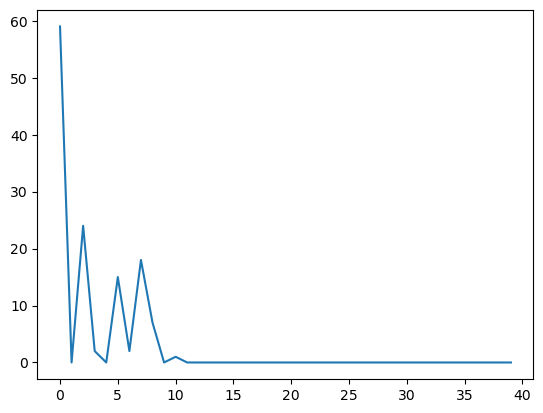

'\nMask the image using the hihgest values so 0-1 and get rid of them \n'

In [8]:
hist = cv2.calcHist(xray_data_red['image'][1], [0], None, [40], [0, 256])
plt.plot(hist)
plt.show()

"""
Mask the image using the hihgest values so 0-1 and get rid of them 
"""

In [9]:
def hist_eq_clahe(image):
    clahe = cv2.createCLAHE(clipLimit= 3, tileGridSize= (8,8))
    img = clahe.apply(image)

    return img 

In [10]:
def normalize_image(image):

    img = image / 255

    return img

In [11]:

def noise_reduce(image):

    img = cv2.GaussianBlur(image, (5,5), 0)
    img = cv2.convertScaleAbs(img)
    
    return img

# Test Preprocessing Techniques

In [12]:
def extract_edge(img):
    img_edge = cv2.Canny(img, 50, 100)
    return img_edge

In [13]:
test_image = hist_eq_clahe(xray_data_red['image'][1])

In [14]:
test_image = extract_edge(test_image)

In [15]:
test_image = normalize_image(test_image)

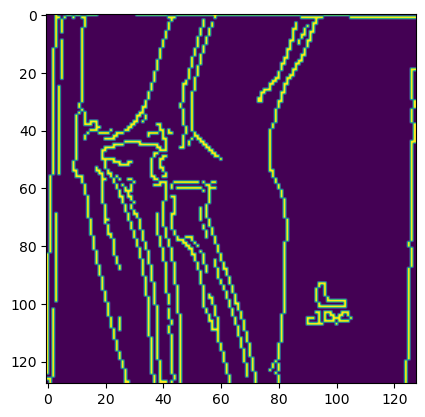

In [16]:
plt.imshow(test_image)
plt.show()


In [17]:
h, w = test_image.shape

In [18]:
test_image = test_image.reshape(-1, 1)

In [19]:
from sklearn.cluster import KMeans

In [20]:
def remove_logo_with_clustering(image, n_clusters=3, logo_cluster=0):
    """
    Removes logos from an X-ray image using unsupervised clustering.
    :param image: Input X-ray image (numpy array, grayscale).
    :param n_clusters: Number of clusters for K-Means.
    :param logo_cluster: Index of the cluster to treat as the logo.
    :return: Image with the logo removed.
    """
    # Normalize the image
    img = cv2.GaussianBlur(image, (7,7), 0)
    img = cv2.convertScaleAbs(img)
    normalized_image = image / 255.0
    h, w = normalized_image.shape

    # Flatten the image
    flat_image = normalized_image.reshape(-1, 1)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(flat_image)
    clustered = kmeans.labels_.reshape(h, w)

    # Identify the logo cluster
    mask = (clustered == logo_cluster).astype(np.uint8) * 255

    # Remove the logo using inpainting
    inpainted_image = cv2.inpaint(image, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inpainted_image, mask


In [21]:
cleaned_img, mask = remove_logo_with_clustering( xray_data_red['image'][1], n_clusters=5, logo_cluster=3)

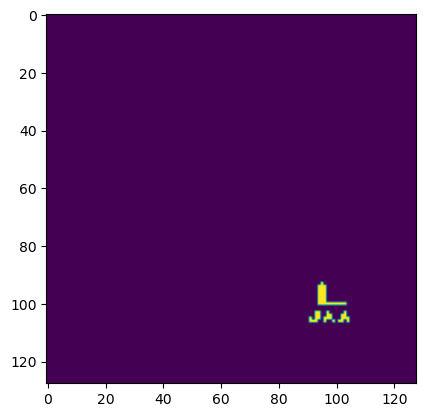

In [22]:
plt.imshow(mask)
plt.show()

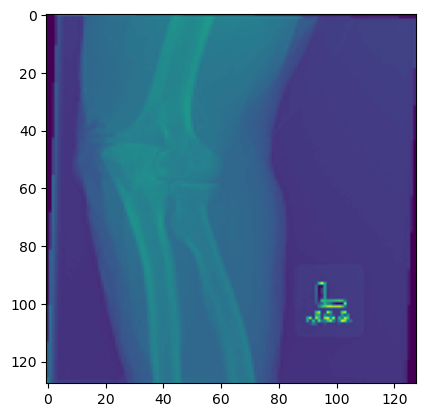

In [23]:
masked_image =cv2.absdiff(xray_data_red['image'][1], mask)

plt.imshow(masked_image)
plt.show()


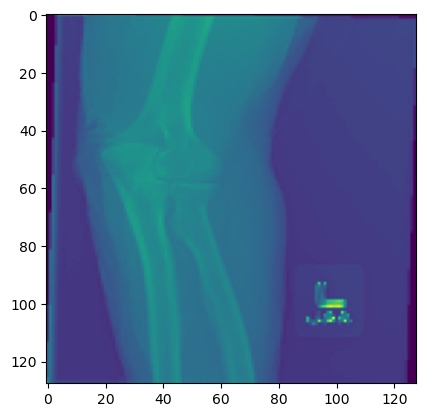

In [24]:
plt.imshow(cleaned_img)
plt.show()

In [25]:
hist = cv2.calcHist([cleaned_img], [0], None, [40], [0, 256])

<function matplotlib.pyplot.show(close=None, block=None)>

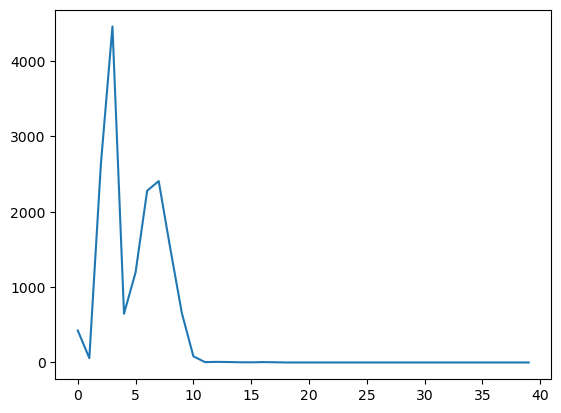

In [26]:
plt.plot(hist)
plt.show

# Segmentation Model Test

In [27]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def build_unet(input_shape=(128, 128, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same')(c6)

    u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(u3)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same')(c7)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)

    return Model(inputs, outputs)

# Build the model
model = build_unet(input_shape=(128, 128, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

In [29]:


history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=20
)

NameError: name 'X_train' is not defined

In [24]:
xray_data_red['image_pre'] = xray_data_red['image'].apply(hist_eq_clahe)
xray_data_red['image_pre'] = xray_data_red['image_pre'].apply(noise_reduce)
xray_data_red['image_pre'] = xray_data_red['image_pre'].apply(normalize_image)

C:\Users\jacob\AppData\Local\Temp\ipykernel_16696\855297759.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['image_pre'] = xray_data_red['image'].apply(hist_eq_clahe)
C:\Users\jacob\AppData\Local\Temp\ipykernel_16696\855297759.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['image_pre'] = xray_data_red['image_pre'].apply(noise_reduce)
C:\Users\jacob\AppData\Local\Temp\ipykernel_16696\855297759.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [12]:
test = xray_data_red['image_pre'][2]
#for i in test:
    #print(i)
#test[100][100] = 1

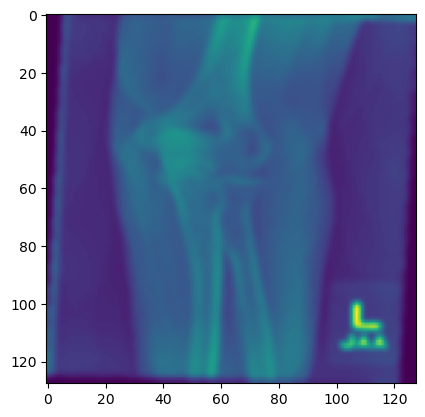

In [13]:
plt.imshow(test)
plt.show()

In [30]:
import ultralytics

# Load the YOLOv8 model
model = ultralytics.YOLO("yolov8n.pt")

# Run inference on the image
results = model(xray_data_red['image_path'][2])

# Print the bounding boxes
for result in results:
    for box in result.boxes:
        print(box.xyxy)  # Coordinates of the bounding box


for result in results:
    boxes = result.boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0].tolist()  # Get bounding box coordinates
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(test, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw green bounding box
        cv2.putText(test, f'{box.cls.item()}:{box.conf.item():.2f}', (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

cv2.imshow('Image', test)
cv2.waitKey(0)
cv2.destroyAllWindows()


image 1/1 c:\Users\jacob\OneDrive\Documents\GitHub\xray_classification_application\MURA-v1.1\train\XR_ELBOW\patient00011\study1_negative\image3.png: 640x448 1 person, 1327.5ms
Speed: 20.7ms preprocess, 1327.5ms inference, 30.6ms postprocess per image at shape (1, 3, 640, 448)
tensor([[ 35.3793,   5.7397, 350.2788, 493.3907]])


NameError: name 'test' is not defined

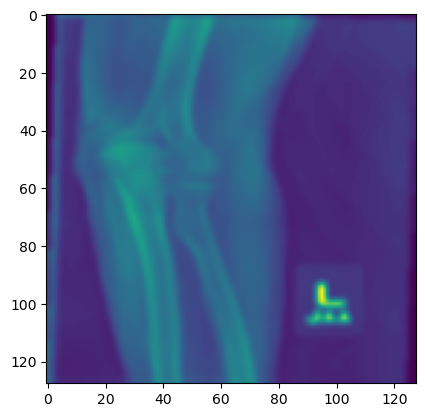

In [ ]:
plt.imshow(xray_data_red['image_pre'][2])
plt.show()

# Unet Part 2

In [31]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model

def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    
    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # Decoder
    up1 = UpSampling2D(size=(2, 2))(conv4)
    merge1 = concatenate([conv3, up1], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    
    up2 = UpSampling2D(size=(2, 2))(conv5)
    merge2 = concatenate([conv2, up2], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    
    up3 = UpSampling2D(size=(2, 2))(conv6)
    merge3 = concatenate([conv1, up3], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    
    # Output layer
    outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Initialize the model with smaller dimensions
model = unet_model(input_size=(128, 128, 1))
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_15[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_17[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_4[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_19[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_5[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_21[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_20[0][0],  │
│ (Concatenate)       │ 768)              │            │ up_sampling2d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │  1,769,728 │ concatenate_3[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 64, 64,    │          0 │ conv2d_24[0][0] 

 Total params: 7,781,761 (29.69 MB)

 Trainable params: 7,781,761 (29.69 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
img_size = (128, 128)
images = []
masks = []

for item in xray_data_red['image']:
    images.append(item)

for item in xray_data_red['mask_image']:
    masks.append(item)


X = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
Y = np.array(masks).reshape(-1, img_size[0], img_size[1], 1)
print(X.shape)
print(Y.shape)

(20, 128, 128, 1)
(20, 128, 128, 1)


In [33]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X, Y, 
    batch_size=8, 
    epochs=10, 
    validation_split=0.2
)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 60s 22s/step - accuracy: 0.0022 - loss: 1.2778 - val_accuracy: 0.0579 - val_loss: 0.6378
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0243 - loss: 0.6208 - val_accuracy: 0.2353 - val_loss: 0.6695
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.0840 - loss: 0.6942 - val_accuracy: 0.3356 - val_loss: 0.6405
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 5s/step - accuracy: 0.0913 - loss: 0.6825 - val_accuracy: 0.3382 - val_loss: 0.5859
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 10s/step - accuracy: 0.1325 - loss: 0.5871 - val_accuracy: 0.3445 - val_loss: 0.5503
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 13s/step - accuracy: 0.0922 - loss: 0.5580 - val_accuracy: 0.3484 - val_loss: 0.5014
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 11s/step - accuracy: 0.0955 - loss: 0.5387 - val_accuracy: 0.3484 - val_loss: 0.4968
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/step - accuracy: 0.1122 - loss: 0.5463 - val_accuracy: 0.3485 - val_loss: 0.4764
Epoch 

In [34]:
predicted_mask = model.predict(X[0:1])[0]
binary_mask = (predicted_mask > 0.5).astype('uint8')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [35]:
import cv2

def remove_logo_with_inpainting(image, mask):
    """
    Remove the logo using inpainting based on the predicted mask.
    :param image: Original X-ray image.
    :param mask: Predicted binary mask for the logo.
    :return: Image with logo removed.
    """
    inpainted_image = cv2.inpaint(image, (mask * 255).astype('uint8'), inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    return inpainted_image

# Example
cleaned_image = remove_logo_with_inpainting(X[0], binary_mask)

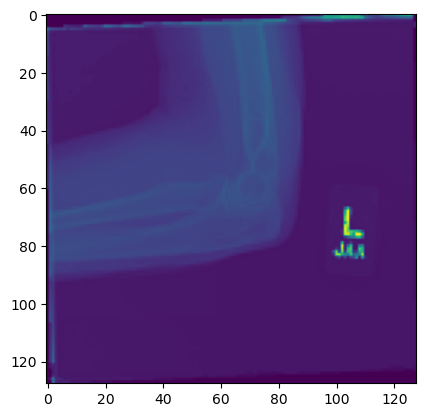

In [36]:
plt.imshow(cleaned_image)
plt.show()

In [166]:
# Predict on test images
preds = model.predict(X[:5])

# Plot results
for i in range(5):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.title("Input Image")
    plt.imshow(X[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(Y[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(preds[i].squeeze(), cmap='gray')
    plt.show()

NameError: name 'X' is not defined

# Preprocessing Techniques

## Types

Historgram Eq.
Noise Reduction 
Contrast Enhancement

In [155]:
def normalize_image(image):

    img = image / 255

    return img

In [18]:
#can experiment with the parameters in guassian blur

def noise_reduce(image):

    img = cv2.GaussianBlur(image, (5,5), 0)
    img = cv2.convertScaleAbs(img)
    
    return img

In [16]:
# tile size and clipt limit expreiment


def hist_eq_clahe(image):
    clahe = cv2.createCLAHE(clipLimit= 3, tileGridSize= (8,8))
    img = clahe.apply(image)

    return img

In [19]:
xray_data_red['image_pre'] = xray_data_red['image'].apply(noise_reduce)

C:\Users\jacob\AppData\Local\Temp\ipykernel_6940\2597121808.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['image_pre'] = xray_data_red['image'].apply(noise_reduce)


In [22]:
xray_data_red['image_pre'] = xray_data_red['image_pre'].apply(hist_eq_clahe)

C:\Users\jacob\AppData\Local\Temp\ipykernel_6940\1136709880.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['image_pre'] = xray_data_red['image_pre'].apply(hist_eq_clahe)


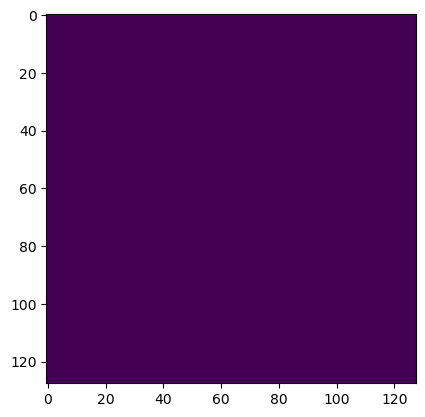

In [23]:
plt.imshow(xray_data_red['image_pre'][3])
plt.show()

In [161]:
#plt.imshow(xray_data_red['image_noise_red_and_eq'][3])
#plt.show()

In [162]:
xray_data_red.head()

,bone_type,patient_id,classifier_type,image_path,image,mask_image,image_pre
0,XR_ELBOW,patient00011,study1_negative,./MURA-v1.1/train\XR_ELBOW\patient00011\study1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
1,XR_ELBOW,patient00011,study1_negative,./MURA-v1.1/train\XR_ELBOW\patient00011\study1...,"[[0, 0, 0, 25, 57, 51, 50, 52, 52, 54, 54, 53,...","[[0, 0, 0, 25, 57, 51, 50, 52, 52, 54, 54, 53,...","[[4, 8, 23, 52, 95, 110, 106, 102, 102, 98, 94..."
2,XR_ELBOW,patient00011,study1_negative,./MURA-v1.1/train\XR_ELBOW\patient00011\study1...,"[[0, 0, 0, 0, 0, 0, 32, 28, 24, 24, 19, 16, 17...","[[0, 0, 0, 0, 0, 0, 32, 28, 24, 24, 19, 16, 17...","[[4, 4, 4, 4, 11, 29, 54, 74, 70, 64, 54, 48, ..."
3,XR_ELBOW,patient00016,study1_positive,./MURA-v1.1/train\XR_ELBOW\patient00016\study1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."
4,XR_ELBOW,patient00016,study1_positive,./MURA-v1.1/train\XR_ELBOW\patient00016\study1...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,..."


In [163]:
#normalize images
xray_data_red['image'] = xray_data_red['image'].apply(normalize_image)
xray_data_red['mask_image'] = xray_data_red['mask_image'].apply(normalize_image)
xray_data_red['image_pre'] = xray_data_red['image_pre'].apply(normalize_image)


C:\Users\jacob\AppData\Local\Temp\ipykernel_17752\603899342.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['image'] = xray_data_red['image'].apply(normalize_image)
C:\Users\jacob\AppData\Local\Temp\ipykernel_17752\603899342.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xray_data_red['mask_image'] = xray_data_red['mask_image'].apply(normalize_image)
C:\Users\jacob\AppData\Local\Temp\ipykernel_17752\603899342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [164]:
df_img_pre = xray_data_red[['image_pre']]

# CNN

In [ ]:
import 

# UNET

In [209]:
from tensorflow import keras
from tensorflow.keras import layers

In [222]:
img_wid = 128
img_height = 128
img_channels = 3

In [234]:
#building model

inputs = tf.keras.layers.Input((img_wid, img_height, img_channels))

s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1= tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2= tf.keras.layers.MaxPooling2D((2,2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3= tf.keras.layers.MaxPooling2D((2,2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4= tf.keras.layers.MaxPooling2D((2,2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#expansive path

u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis = 3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [235]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 128, 128, 3)  0           ['input_15[0][0]']               
                                                                                                  
 conv2d_181 (Conv2D)            (None, 128, 128, 16  448         ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

In [194]:
def create_num_labels(label):
    if label == 'study1_negative':
        label = 0
    
    else:
        label = 1

    return label

labels = xray_data['classifier_type'].apply(create_num_labels)
labels = labels[0:1000]

In [238]:
X = xray_data_red['image'].to_list()
Y = xray_data_red['mask_image'].to_list()




In [240]:
#model checkpoint

check_pointer = tf.keras.callbacks.ModelCheckpoint('model_smart_bone', verbose=1, save_best_only=True)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
]

results = model.fit(X, Y, validation_split=0.1, batch_size=16, epochs=15, callbacks=callbacks)

Epoch 1/15


ValueError: in user code:

    File "c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_8" expects 1 input(s), but it received 1000 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:3' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:4' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:5' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:6' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:7' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:8' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:9' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:10' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:11' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:12' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:13' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:14' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:15' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:16' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:17' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:18' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:19' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:20' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:21' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:22' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:23' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:24' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:25' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:26' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:27' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:28' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:29' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:30' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:31' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:32' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:33' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:34' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:35' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:36' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:37' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:38' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:39' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:40' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:41' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:42' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:43' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:44' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:45' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:46' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:47' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:48' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:49' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:50' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:51' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:52' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:53' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:54' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:55' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:56' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:57' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:58' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:59' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:60' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:61' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:62' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:63' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:64' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:65' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:66' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:67' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:68' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:69' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:70' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:71' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:72' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:73' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:74' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:75' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:76' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:77' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:78' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:79' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:80' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:81' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:82' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:83' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:84' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:85' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:86' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:87' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:88' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:89' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:90' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:91' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:92' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:93' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:94' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:95' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:96' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:97' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:98' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:99' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:100' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:101' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:102' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:103' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:104' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:105' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:106' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:107' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:108' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:109' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:110' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:111' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:112' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:113' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:114' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:115' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:116' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:117' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:118' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:119' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:120' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:121' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:122' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:123' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:124' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:125' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:126' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:127' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:128' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:129' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:130' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:131' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:132' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:133' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:134' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:135' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:136' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:137' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:138' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:139' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:140' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:141' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:142' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:143' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:144' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:145' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:146' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:147' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:148' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:149' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:150' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:151' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:152' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:153' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:154' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:155' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:156' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:157' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:158' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:159' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:160' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:161' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:162' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:163' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:164' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:165' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:166' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:167' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:168' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:169' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:170' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:171' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:172' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:173' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:174' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:175' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:176' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:177' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:178' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:179' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:180' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:181' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:182' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:183' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:184' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:185' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:186' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:187' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:188' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:189' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:190' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:191' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:192' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:193' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:194' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:195' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:196' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:197' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:198' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:199' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:200' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:201' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:202' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:203' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:204' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:205' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:206' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:207' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:208' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:209' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:210' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:211' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:212' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:213' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:214' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:215' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:216' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:217' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:218' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:219' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:220' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:221' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:222' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:223' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:224' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:225' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:226' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:227' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:228' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:229' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:230' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:231' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:232' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:233' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:234' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:235' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:236' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:237' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:238' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:239' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:240' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:241' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:242' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:243' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:244' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:245' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:246' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:247' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:248' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:249' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:250' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:251' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:252' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:253' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:254' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:255' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:256' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:257' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:258' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:259' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:260' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:261' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:262' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:263' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:264' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:265' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:266' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:267' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:268' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:269' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:270' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:271' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:272' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:273' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:274' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:275' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:276' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:277' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:278' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:279' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:280' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:281' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:282' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:283' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:284' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:285' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:286' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:287' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:288' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:289' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:290' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:291' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:292' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:293' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:294' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:295' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:296' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:297' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:298' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:299' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:300' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:301' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:302' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:303' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:304' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:305' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:306' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:307' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:308' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:309' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:310' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:311' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:312' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:313' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:314' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:315' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:316' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:317' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:318' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:319' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:320' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:321' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:322' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:323' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:324' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:325' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:326' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:327' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:328' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:329' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:330' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:331' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:332' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:333' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:334' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:335' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:336' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:337' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:338' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:339' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:340' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:341' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:342' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:343' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:344' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:345' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:346' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:347' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:348' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:349' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:350' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:351' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:352' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:353' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:354' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:355' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:356' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:357' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:358' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:359' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:360' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:361' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:362' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:363' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:364' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:365' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:366' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:367' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:368' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:369' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:370' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:371' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:372' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:373' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:374' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:375' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:376' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:377' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:378' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:379' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:380' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:381' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:382' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:383' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:384' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:385' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:386' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:387' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:388' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:389' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:390' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:391' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:392' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:393' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:394' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:395' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:396' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:397' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:398' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:399' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:400' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:401' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:402' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:403' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:404' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:405' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:406' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:407' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:408' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:409' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:410' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:411' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:412' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:413' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:414' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:415' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:416' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:417' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:418' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:419' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:420' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:421' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:422' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:423' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:424' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:425' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:426' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:427' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:428' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:429' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:430' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:431' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:432' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:433' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:434' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:435' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:436' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:437' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:438' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:439' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:440' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:441' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:442' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:443' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:444' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:445' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:446' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:447' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:448' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:449' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:450' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:451' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:452' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:453' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:454' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:455' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:456' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:457' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:458' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:459' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:460' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:461' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:462' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:463' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:464' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:465' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:466' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:467' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:468' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:469' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:470' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:471' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:472' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:473' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:474' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:475' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:476' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:477' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:478' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:479' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:480' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:481' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:482' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:483' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:484' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:485' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:486' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:487' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:488' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:489' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:490' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:491' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:492' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:493' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:494' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:495' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:496' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:497' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:498' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:499' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:500' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:501' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:502' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:503' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:504' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:505' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:506' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:507' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:508' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:509' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:510' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:511' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:512' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:513' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:514' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:515' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:516' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:517' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:518' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:519' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:520' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:521' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:522' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:523' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:524' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:525' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:526' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:527' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:528' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:529' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:530' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:531' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:532' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:533' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:534' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:535' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:536' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:537' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:538' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:539' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:540' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:541' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:542' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:543' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:544' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:545' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:546' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:547' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:548' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:549' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:550' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:551' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:552' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:553' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:554' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:555' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:556' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:557' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:558' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:559' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:560' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:561' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:562' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:563' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:564' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:565' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:566' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:567' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:568' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:569' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:570' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:571' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:572' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:573' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:574' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:575' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:576' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:577' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:578' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:579' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:580' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:581' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:582' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:583' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:584' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:585' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:586' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:587' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:588' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:589' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:590' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:591' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:592' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:593' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:594' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:595' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:596' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:597' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:598' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:599' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:600' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:601' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:602' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:603' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:604' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:605' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:606' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:607' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:608' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:609' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:610' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:611' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:612' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:613' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:614' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:615' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:616' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:617' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:618' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:619' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:620' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:621' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:622' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:623' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:624' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:625' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:626' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:627' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:628' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:629' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:630' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:631' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:632' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:633' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:634' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:635' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:636' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:637' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:638' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:639' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:640' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:641' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:642' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:643' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:644' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:645' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:646' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:647' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:648' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:649' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:650' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:651' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:652' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:653' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:654' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:655' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:656' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:657' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:658' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:659' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:660' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:661' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:662' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:663' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:664' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:665' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:666' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:667' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:668' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:669' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:670' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:671' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:672' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:673' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:674' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:675' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:676' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:677' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:678' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:679' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:680' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:681' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:682' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:683' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:684' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:685' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:686' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:687' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:688' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:689' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:690' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:691' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:692' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:693' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:694' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:695' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:696' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:697' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:698' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:699' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:700' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:701' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:702' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:703' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:704' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:705' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:706' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:707' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:708' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:709' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:710' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:711' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:712' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:713' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:714' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:715' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:716' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:717' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:718' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:719' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:720' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:721' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:722' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:723' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:724' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:725' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:726' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:727' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:728' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:729' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:730' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:731' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:732' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:733' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:734' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:735' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:736' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:737' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:738' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:739' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:740' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:741' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:742' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:743' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:744' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:745' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:746' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:747' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:748' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:749' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:750' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:751' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:752' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:753' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:754' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:755' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:756' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:757' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:758' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:759' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:760' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:761' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:762' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:763' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:764' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:765' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:766' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:767' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:768' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:769' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:770' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:771' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:772' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:773' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:774' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:775' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:776' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:777' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:778' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:779' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:780' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:781' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:782' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:783' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:784' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:785' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:786' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:787' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:788' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:789' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:790' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:791' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:792' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:793' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:794' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:795' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:796' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:797' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:798' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:799' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:800' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:801' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:802' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:803' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:804' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:805' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:806' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:807' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:808' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:809' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:810' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:811' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:812' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:813' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:814' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:815' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:816' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:817' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:818' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:819' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:820' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:821' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:822' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:823' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:824' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:825' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:826' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:827' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:828' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:829' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:830' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:831' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:832' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:833' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:834' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:835' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:836' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:837' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:838' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:839' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:840' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:841' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:842' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:843' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:844' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:845' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:846' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:847' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:848' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:849' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:850' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:851' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:852' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:853' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:854' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:855' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:856' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:857' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:858' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:859' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:860' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:861' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:862' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:863' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:864' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:865' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:866' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:867' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:868' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:869' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:870' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:871' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:872' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:873' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:874' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:875' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:876' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:877' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:878' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:879' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:880' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:881' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:882' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:883' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:884' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:885' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:886' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:887' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:888' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:889' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:890' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:891' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:892' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:893' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:894' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:895' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:896' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:897' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:898' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:899' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:900' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:901' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:902' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:903' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:904' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:905' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:906' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:907' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:908' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:909' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:910' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:911' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:912' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:913' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:914' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:915' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:916' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:917' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:918' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:919' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:920' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:921' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:922' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:923' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:924' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:925' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:926' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:927' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:928' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:929' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:930' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:931' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:932' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:933' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:934' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:935' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:936' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:937' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:938' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:939' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:940' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:941' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:942' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:943' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:944' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:945' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:946' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:947' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:948' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:949' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:950' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:951' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:952' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:953' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:954' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:955' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:956' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:957' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:958' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:959' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:960' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:961' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:962' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:963' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:964' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:965' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:966' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:967' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:968' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:969' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:970' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:971' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:972' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:973' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:974' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:975' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:976' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:977' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:978' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:979' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:980' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:981' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:982' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:983' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:984' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:985' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:986' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:987' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:988' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:989' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:990' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:991' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:992' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:993' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:994' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:995' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:996' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:997' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:998' shape=(None, 128, 3) dtype=uint8>, <tf.Tensor 'IteratorGetNext:999' shape=(None, 128, 3) dtype=uint8>]


# Classification

In [48]:
from skimage.feature import graycomatrix, graycoprops
from skimage.feature import hog
from skimage.feature import local_binary_pattern


def hist_of_grads_feature_extract(image_array):
    features, _ = hog(
        image_array, 
        orientations=8, 
        pixels_per_cell=(16, 16), 
        cells_per_block=(2, 2), 
        visualize=True, 

    )
    return features

def hog_test_image(image):
    features, hog_img = hog(
        image, 
        orientations=8, 
        pixels_per_cell=(16, 16), 
        cells_per_block=(2, 2), 
        visualize=True, 

    )
    return features, hog_img


def extract_lbp_features(image_array, radius=3, n_points=24):
    lbp = local_binary_pattern(image_array, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize
    return hist


In [33]:
df_img_hist_noise['hog_features'] = df_img_hist_noise['image_noise_red_and_eq'].apply(hist_of_grads_feature_extract)

C:\Users\jacob\AppData\Local\Temp\ipykernel_17752\2470405085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_img_hist_noise['hog_features'] = df_img_hist_noise['image_noise_red_and_eq'].apply(hist_of_grads_feature_extract)


In [45]:
hogfeat, hog_img = hog_test_image(df_img_hist_noise['image_noise_red_and_eq'][0])

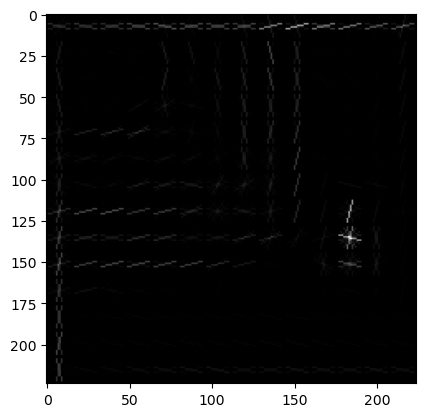

In [47]:
plt.imshow(hog_img, cmap=plt.cm.gray)
plt.show()

In [49]:
df_img_hist_noise['lbp_features'] = df_img_hist_noise['image_noise_red_and_eq'].apply(extract_lbp_features)

c:\Users\jacob\anaconda3\envs\tf\lib\site-packages\skimage\feature\texture.py:360: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
C:\Users\jacob\AppData\Local\Temp\ipykernel_17752\575809555.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_img_hist_noise['lbp_features'] = df_img_hist_noise['image_noise_red_and_eq'].apply(extract_lbp_features)


In [50]:
df_img_hist_noise['combined_features'] = df_img_hist_noise.apply(
    lambda row: np.concatenate([
        row['hog_features'], 
        row['lbp_features']
    ]),
    axis=1
)

C:\Users\jacob\AppData\Local\Temp\ipykernel_17752\18009656.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_img_hist_noise['combined_features'] = df_img_hist_noise.apply(


In [51]:
df_img_hist_noise.head()

,image_noise_red_and_eq,hog_features,lbp_features,combined_features
0,"[[0.01568627450980392, 0.01568627450980392, 0....","[0.060510631669460656, 0.15859726252783646, 0....","[0.008390465561207767, 0.011459661989773079, 0...","[0.060510631669460656, 0.15859726252783646, 0...."
1,"[[0.01568627450980392, 0.01568627450980392, 0....","[0.4247948101599949, 0.03301651229289565, 0.02...","[0.011300223214263192, 0.011818399234670323, 0...","[0.4247948101599949, 0.03301651229289565, 0.02..."
2,"[[0.01568627450980392, 0.01568627450980392, 0....","[0.5480021686835373, 0.04831538923224479, 0.00...","[0.012396364795893662, 0.013950892857115054, 0...","[0.5480021686835373, 0.04831538923224479, 0.00..."
3,"[[0.01568627450980392, 0.01568627450980392, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.006497130102027867, 0.008350605867330297, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[[0.01568627450980392, 0.01568627450980392, 0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.005879304846927058, 0.007154815051006148, 0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [52]:
from sklearn.preprocessing import StandardScaler

X = np.stack(df_img_hist_noise['combined_features'].values)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)


In [72]:
sum1 = 0
sum2 = 0
for i in labels:
    if i == 0:
        sum1+=1 

    else:
        sum2 += 1

print(sum1)
print(sum2)


414
586


In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_norm, labels, test_size=0.2, random_state=42
)

In [59]:
from sklearn.svm import SVC

# Train an SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.6100
Precision: 0.6881
Recall: 0.6303
F1 Score: 0.6579


In [61]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1, 1]
}

# Grid search
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Best parameters: {'C': 0.1, 'gamma': 0.01, 'kernel': 'linear'}
Best accuracy: 0.58875


# Hog

In [82]:
from sklearn.preprocessing import StandardScaler

X = np.stack(df_img_hist_noise['hog_features'].values)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split



In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% variance
reduced_features = pca.fit_transform(X_norm)

In [84]:
X_train, X_test, y_train, y_test = train_test_split(
    reduced_features, labels, test_size=0.2, random_state=42
)

In [85]:
from sklearn.svm import SVC

# Train an SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6200
Precision: 0.6937
Recall: 0.6471
F1 Score: 0.6696


# LBP featuers

In [76]:
from sklearn.preprocessing import StandardScaler

X = np.stack(df_img_hist_noise['lbp_features'].values)

scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split



In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% variance
reduced_features = pca.fit_transform(X_norm)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    reduced_features, labels, test_size=0.2, random_state=42
)

In [81]:
from sklearn.svm import SVC

# Train an SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.6050
Precision: 0.6266
Recall: 0.8319
F1 Score: 0.7148
